In [1]:
import sys
print(sys.executable)


/home/gotou/miniconda3/envs/myenv/bin/python


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import h5py
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

# 1. 癌特異的データ拡張クラス
class CancerSpecificAugment:
    def __call__(self, img, label):
        if label == 1:
            img = transforms.functional.adjust_sharpness(img, 2.0)
            img = transforms.functional.adjust_contrast(img, 1.2)
        return img

# 2. カスタムデータセットクラス
class PCamDataset(Dataset):
    def __init__(self, h5_x_path, h5_y_path, transform=None):
        self.x_h5 = h5py.File(h5_x_path, 'r')['x']
        self.y_h5 = h5py.File(h5_y_path, 'r')['y']
        self.transform = transform
        self.augment = CancerSpecificAugment()

    def __getitem__(self, idx):
        image = self.x_h5[idx]
        label = self.y_h5[idx].item()
        image = transforms.ToPILImage()(image)
        if self.transform:
            image = self.transform(image)
        image = self.augment(image, label)
        return image, label

    def __len__(self):
        return len(self.y_h5)

# 3. Focal Lossの実装
class FocalLoss(nn.Module):
    def __init__(self, alpha=[0.1, 0.9], gamma=2.0):
        super().__init__()
        self.alpha = torch.tensor(alpha).cuda()
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        alpha_t = self.alpha.gather(0, targets)
        focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# 4. ハイパーパラメータと前処理
mean = [0.702, 0.538, 0.691]
std = [0.238, 0.279, 0.213]

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# 5. データセットとローダー
train_dataset = PCamDataset('camelyonpatch_level_2_split_train_x.h5', 'camelyonpatch_level_2_split_train_y.h5', transform=transform_train)
val_dataset = PCamDataset('valid_x_uncompressed.h5', 'valid_y_uncompressed.h5', transform=transform_test)
test_dataset = PCamDataset('camelyonpatch_level_2_split_test_x.h5', 'camelyonpatch_level_2_split_test_y.h5', transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# 6. モデル準備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
for param in model.parameters():
    param.requires_grad = True
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2)
)
model = model.to(device)

# 7. 損失関数、最適化、スケジューラ
criterion = FocalLoss(alpha=[0.1, 0.9])
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-4,
    steps_per_epoch=len(train_loader),
    epochs=30
)

# 8. 学習ループ
best_val_acc = 0.0
patience = 3
no_improve = 0
best_val_loss = float('inf')

for epoch in range(30):
    model.train()
    total_loss, total_correct, total = 0, 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/30")

    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        total_correct += preds.eq(labels).sum().item()
        pbar.set_postfix({"Loss": f"{total_loss/(pbar.n+1):.4f}", "Acc": f"{100.*total_correct/total:.2f}%"})

    # バリデーション
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = outputs.max(1)
            val_total += labels.size(0)
            val_correct += preds.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.2f}%, Loss: {val_loss/len(val_loader):.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved!")

    current_val_loss = val_loss / len(val_loader)
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# 9. テスト精度と分類レポート
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        y_true += labels.cpu().tolist()
        y_pred += preds.cpu().tolist()

print("Test Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Cancer", "Cancer"]))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Epoch 1/30: 100%|██████████| 8192/8192 [07:04<00:00, 19.32it/s, Loss=0.0014, Acc=98.48%]


Validation Accuracy: 99.91%, Loss: 0.0001
Best model saved!


Epoch 2/30:  25%|██▌       | 2075/8192 [01:44<05:07, 19.87it/s, Loss=0.0000, Acc=99.99%] 


KeyboardInterrupt: 

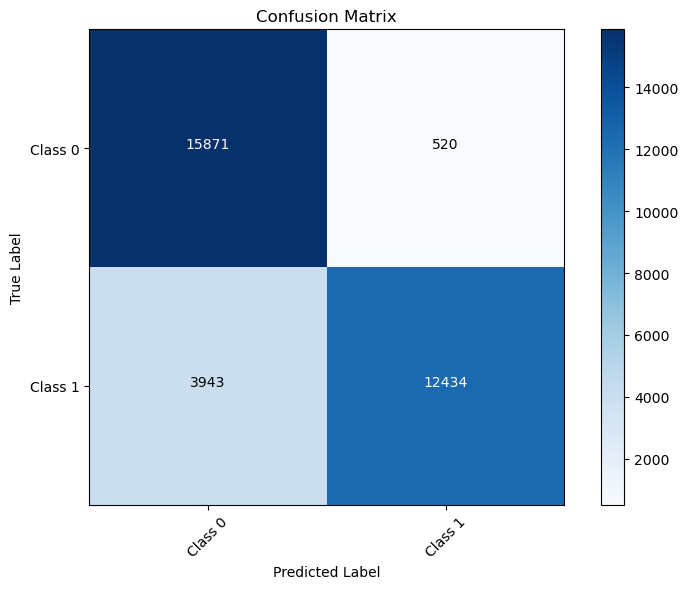

Overall Test Accuracy: 86.38%
Class 0 Accuracy: 96.83%
Class 0 False Alarms: 3943
Class 1 Accuracy: 75.92%
Class 1 False Alarms: 520


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. 予測値と正解ラベルの収集
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# 2. 混同行列を手動で計算する関数
def plot_confusion_matrix(true_labels, pred_labels, classes):
    """
    手動で混同行列を計算し可視化
    :param true_labels: 正解ラベルのリスト
    :param pred_labels: 予測ラベルのリスト
    :param classes: クラス名のリスト（例: ['Normal', 'Tumor']）
    """
    n_classes = len(classes)
    cm = np.zeros((n_classes, n_classes), dtype=int)
    
    for t, p in zip(true_labels, pred_labels):
        cm[t, p] += 1
    
    # 可視化
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # セル内に数値を表示
    thresh = cm.max() / 2.
    for i in range(n_classes):
        for j in range(n_classes):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.show()
    
    return cm

# 3. 混同行列の表示
classes = ['Class 0', 'Class 1']  # 実際のクラス名に変更
cm = plot_confusion_matrix(all_labels, all_preds, classes)

# 4. 精度レポート
test_acc = 100 * np.sum(np.diag(cm)) / np.sum(cm)
print(f"Overall Test Accuracy: {test_acc:.2f}%")

for i, class_name in enumerate(classes):
    accuracy = 100 * cm[i,i] / np.sum(cm[i])
    print(f"{class_name} Accuracy: {accuracy:.2f}%")
    print(f"{class_name} False Alarms: {np.sum(cm[:,i]) - cm[i,i]}")